# Predicting price

In [1]:
#as some executions are too long, code will be writen as comenst, obtained results are stored in pickle
import pickle

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import re
from matplotlib import style
style.use('fivethirtyeight')
import time
import datetime
from pandas import HDFStore, DataFrame, read_csv, concat, options
options.mode.chained_assignment = None

In [3]:
data = pickle.load(open('filtered_df','rb'))
print(data.shape)
data.head()
print(data.columns)

y=data['price']

(46241, 11)
Index(['price', 'name', 'neighbourhood_group', 'room_type', 'minimum_nights',
       'last_review', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'host_id'],
      dtype='object')


# Data Exploration and Pre-processing

In [4]:
from sklearn.model_selection import train_test_split
data_train, data_test, y_train, y_test = train_test_split(data,y,test_size=0.2,random_state = 3)

In [5]:
def data_transformer(df = data_train,train_df = data_train):
    X_df = df
    for categorical_variable in ['room_type','neighbourhood_group']:
        X_df = pd.concat([X_df,pd.get_dummies(df[categorical_variable])],axis=1)
        X_df.drop(columns=[categorical_variable],inplace=True)
    to_fill = df['last_review'].max()+datetime.timedelta(days=10)
    df['last_review'].fillna(to_fill,inplace=True)
    X_df['last_review_scale'] = (df['last_review'].max()-df['last_review']).dt.days
    X_df.drop(columns=['last_review'],inplace=True)
    
    X_df['reviews_per_month'].apply(lambda i: i if i<20 else 20)
    
    X_df['month']=df['number_of_reviews']/df['reviews_per_month']
    X_df['month'].fillna(0,inplace=True)
    
    X_df['minimum_nights'].apply(lambda i: i if i<500 else 500)
    
    X_df['data_mean_owner'] = pd.Series(index=X_df.index)
    host_id = list(X_df[X_df['calculated_host_listings_count']>1]['host_id'])
    for i in host_id:
        mean_ = train_df[train_df['host_id']==i]['price'].mean()
        I = X_df[X_df['host_id']==i].index
        X_df.loc[I,'data_mean_owner'] = mean_
    X_df['data_mean_owner'].fillna(0,inplace=True)
    X_df.drop(columns=['host_id'])
    return X_df

In [6]:
X_df_train = data_transformer(df = data_train,train_df = data_train)
X_df_train.drop(columns=['price'],inplace=True)
X_df_train.head()

,name,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_id,Entire home/apt,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island,last_review_scale,month,data_mean_owner
36791,sun new york home east villag,3,7,0.91,1,4,24074596,1,0,0,0,0,1,0,0,39,7.692308,0.0
14624,spaciou rm w privat beaut,14,2,0.06,1,0,27751504,0,1,0,0,1,0,0,0,444,33.333333,0.0
17543,privat bd weekend,1,1,0.03,1,0,17153180,0,1,0,0,1,0,0,0,1107,33.333333,0.0
27313,larg bright fulli furnish rm 3bd bd apt,4,0,0.00,1,0,3053519,0,1,0,0,0,1,0,0,0,0.000000,0.0
48502,bd privat beaut 20min min manhattan,1,0,0.00,1,177,45919617,0,1,0,0,0,0,1,0,0,0.000000,0.0


In [7]:
X_df_test = data_transformer(df = data_test,train_df = data_train)
X_df_test.drop(columns=['price'],inplace=True)
X_df_test.head()

,name,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_id,Entire home/apt,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island,last_review_scale,month,data_mean_owner
33332,park slope secret garden,4,5,0.46,1,12,65884218,1,0,0,0,1,0,0,0,198,10.869565,0.0
33899,bear b,1,43,3.58,4,81,191571338,0,1,0,0,0,0,1,0,13,12.011173,59.0
26454,20min min sub ride time sq,2,1,0.05,1,0,151683441,0,1,0,0,0,0,1,0,575,20.000000,0.0
24222,one bd apt prospect park,2,5,0.22,1,0,18327839,1,0,0,0,1,0,0,0,662,22.727273,0.0
42321,cozi modern 1bed bed apt hell kitchen,3,0,0.00,1,0,4087531,1,0,0,0,0,1,0,0,0,0.000000,0.0


## Extracting words from the cleared text data

we have to use train data set to prevent data leakage

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(max_df = 0.1,min_df=0.00003)
features_name = count.fit_transform(X_df_train['name'])
print(features_name.shape[1])
print(type(features_name))

words_df = pd.DataFrame(features_name.toarray(), columns=count.get_feature_names())
X_all_words = words_df.to_numpy()
print(words_df.columns[:10],words_df.columns[3000:3010],words_df.columns[-10:])


features_name_test = count.transform(X_df_test['name'])
words_df_test = pd.DataFrame(features_name_test.toarray(), columns=count.get_feature_names())
X_test_words = words_df_test.to_numpy()

2616
<class 'scipy.sparse.csr.csr_matrix'>
Index(['000sf', '000sq', '0min', '1000sq', '100night', '100privat', '105th',
       '108th', '10day', '10foot'],
      dtype='object') Index([], dtype='object') Index(['yorkvil', 'young', 'youth', 'yr', 'yurt', 'zen', 'zimmer', 'zona',
       'zone', 'zoo'],
      dtype='object')


## PLS

In [9]:
start_time = time.time()
score_all_words = []
from sklearn.cross_decomposition import PLSRegression
for i in range(1,16):
    pls = PLSRegression(n_components=i)
    pls.fit(X_all_words,y_train)
    score_all_words.append(pls.score(X_all_words,y_train))
    print('iteration '+str(i)+'/15 is over')
    pickle.dump(pls, open('pls_words_'+str(i), 'wb'))
print("--- %s minuts ---" % ((time.time() - start_time)/60))

iteration 1/15 is over
iteration 2/15 is over
iteration 3/15 is over
iteration 4/15 is over
iteration 5/15 is over
iteration 6/15 is over
iteration 7/15 is over
iteration 8/15 is over
iteration 9/15 is over
iteration 10/15 is over
iteration 11/15 is over
iteration 12/15 is over
iteration 13/15 is over
iteration 14/15 is over
iteration 15/15 is over
--- 2.407628067334493 minuts ---


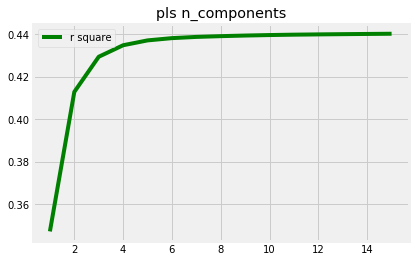

In [10]:
plt.plot(range(1,16),score_all_words,'g',label = 'r square')
plt.title('pls n_components')
plt.legend()

In [11]:
pls_words_6 = pickle.load(open('pls_words_6','rb'))
X_words_train = pls_words_6.transform(X_all_words)
X_words_test = pls_words_6.transform(X_test_words)

In [12]:
X_df_train.drop(columns=['name'],inplace=True)
X_train = np.concatenate([X_words_train,X_df_train.to_numpy()],axis=1)
print(X_train.shape)
X_df_test.drop(columns=['name'],inplace=True)
X_test = np.concatenate([X_words_test,X_df_test.to_numpy()],axis=1)

(36992, 23)


# Regression task

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

dict_to_compare_test = {}
dict_to_compare_train = {}

In [15]:
from sklearn.linear_model import LassoCV
lr = LassoCV(alphas=[0.0005,0.001,0.005,0.01],cv=4)
lasso_fit = lr.fit(scaler.fit_transform(X_train),y_train)
y_lr_train_pred = lr.predict(scaler.transform(X_train))
y_lr_test_pred = lr.predict(scaler.transform(X_test))
dict_to_compare_train['Linear regression'] = MSE(y_train,y_lr_train_pred)**0.5
dict_to_compare_test['Linear regression'] = MSE(y_test,y_lr_test_pred)**0.5
print(dict_to_compare_train['Linear regression'])
print(dict_to_compare_test['Linear regression'])

print('lr.alpha = ',lr.alpha_)

49.75833445540639
51.31559810039941
lr.alpha =  0.005


### Decision tree regressor

In [16]:
from sklearn.tree import DecisionTreeRegressor
start_time = time.time()

train_line_loss_dt_reg= []
test_line_loss_dt_reg = []

for i in range(1,11):
    dt_i = DecisionTreeRegressor(max_depth=i,random_state=21,min_samples_split=0.1,min_samples_leaf=0.1)
    dt_i.fit(X_train,y_train)

    y_dt_reg_train_pred = dt_i.predict(X_train)
    y_dt_reg_test_pred = dt_i.predict(X_test)
    
    train_line_loss_dt_reg.append((MSE(y_train,y_dt_reg_train_pred))**0.5)
    test_line_loss_dt_reg.append((MSE(y_test,y_dt_reg_test_pred))**0.5)
    pickle.dump(dt_i, open('dt_reg_'+str(i), 'wb'))
    print('iteration '+str(i)+'/20 is over')
print("--- %s seconds ---" % (time.time() - start_time))

iteration 1/20 is over
iteration 2/20 is over
iteration 3/20 is over
iteration 4/20 is over
iteration 5/20 is over
iteration 6/20 is over
iteration 7/20 is over
iteration 8/20 is over
iteration 9/20 is over
iteration 10/20 is over
--- 1.3126966953277588 seconds ---


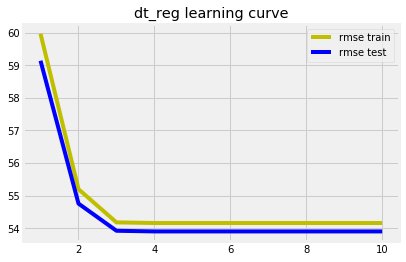

In [17]:
plt.plot(range(1,11),train_line_loss_dt_reg,'y',label = 'rmse train')
plt.plot(range(1,11),test_line_loss_dt_reg,'b', label = 'rmse test')
plt.title('dt_reg learning curve')
plt.legend()

In [25]:
start_time = time.time()
dt_reg_ = DecisionTreeRegressor(random_state=1)
params_dt_reg_ = {'max_depth':[7,9,11,13],
                  'min_samples_leaf':[2,0.1,0.01],
                 'min_samples_split':[2,0.1,0.01]}
grid_dt = GridSearchCV(estimator=dt_reg_,param_grid=params_dt_reg_,cv=4,n_jobs=-1)
grid_dt.fit(X_train,y_train)
best_model = grid_dt.best_estimator_
pickle.dump(best_model,open('best_model_dt','wb'))
print(grid_dt.best_params_ )
print("--- %s minuts ---" % ((time.time() - start_time)/60))

best_model_dt = pickle.load(open('best_model_dt','rb'))
y_dt_gs_train_pred = best_model_dt.predict(X_train)
y_dt_gs_test_pred = best_model_dt.predict(X_test)
dict_to_compare_train['Decision tree'] = MSE(y_train,y_dt_gs_train_pred)**0.5
dict_to_compare_test['Decision tree'] = MSE(y_test,y_dt_gs_test_pred)**0.5
print('rmse train = ',dict_to_compare_train['Decision tree'],'\nrmse test = ',dict_to_compare_test['Decision tree'])

{'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 0.01}
--- 0.21781484683354696 minuts ---
rmse train =  45.777468675960385 
rmse test =  50.65315178289495


### Random forest

In [26]:
from  sklearn.ensemble import RandomForestRegressor

start_time = time.time()
train_line_loss_rf = []
test_line_loss_rf = []

for i in range(1,21):
    rf =  RandomForestRegressor(n_estimators=i,random_state=1,min_samples_leaf=0.01,min_samples_split=0.1,max_features=0.07)
    rf.fit(X_train,y_train)
    y_rf_train_pred = rf.predict(X_train)
    y_rf_test_pred = rf.predict(X_test)
    train_line_loss_rf.append((MSE(y_train,y_rf_train_pred))**0.5)
    test_line_loss_rf.append((MSE(y_test,y_rf_test_pred))**0.5)
    print('iteration '+str(i)+'/20 is over')
print("--- %s seconds ---" % (time.time() - start_time))

iteration 1/20 is over
iteration 2/20 is over
iteration 3/20 is over
iteration 4/20 is over
iteration 5/20 is over
iteration 6/20 is over
iteration 7/20 is over
iteration 8/20 is over
iteration 9/20 is over
iteration 10/20 is over
iteration 11/20 is over
iteration 12/20 is over
iteration 13/20 is over
iteration 14/20 is over
iteration 15/20 is over
iteration 16/20 is over
iteration 17/20 is over
iteration 18/20 is over
iteration 19/20 is over
iteration 20/20 is over
--- 2.156564235687256 seconds ---


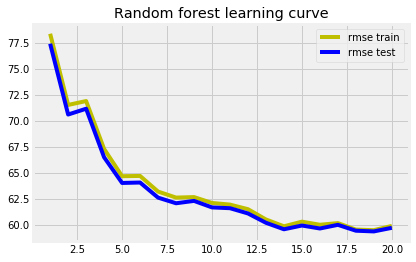

In [27]:
plt.plot(range(1,21),train_line_loss_rf,'y',label = 'rmse train')
plt.plot(range(1,21),test_line_loss_rf,'b', label = 'rmse test')
plt.title('Random forest learning curve')
plt.legend()

In [28]:
start_time = time.time()
from  sklearn.ensemble import RandomForestRegressor
rf_ = RandomForestRegressor(random_state=1)
params_rf = {'n_estimators':[20,30,40,50],
             'min_samples_leaf':[0.01,0.1],
            'min_samples_split':[0.01,0.1],
            'max_features':[0.2,0.25,0.3,0.4,0.5]}
grid_rf = GridSearchCV(estimator=rf_,param_grid=params_rf,cv=4,n_jobs=-1,verbose=1)
grid_rf.fit(X_train,y_train)
best_model = grid_rf.best_estimator_
pickle.dump(best_model,open('best_model_rf','wb'))
print(grid_rf.best_params_)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

best_model_rf = pickle.load(open('best_model_rf','rb'))
y_rf_gs_train_pred = best_model_rf.predict(X_train)
y_rf_gs_test_pred = best_model_rf.predict(X_test)
dict_to_compare_train['Random forest'] = MSE(y_train,y_rf_gs_train_pred)**0.5
dict_to_compare_test['Random forest'] = MSE(y_test,y_dt_gs_test_pred)**0.5
print('rmse train = ',dict_to_compare_train['Random forest'],'\nrmse test = ',dict_to_compare_test['Random forest'])

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.2min finished


{'max_features': 0.5, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 50}
--- 2.29798082113266 minuts ---
rmse train =  47.56997651220204 
rmse test =  50.65315178289495


### Adaboost

In [29]:
from sklearn.ensemble import AdaBoostRegressor

train_line_loss_ada = []
test_line_loss_ada = []

for i in range(1,16):
    regr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=2,min_samples_leaf=0.01,min_samples_split=0.01),random_state=21, n_estimators=i)
    regr.fit(X_train, y_train)
    y_ada_train_pred = regr.predict(X_train)
    y_ada_test_pred = regr.predict(X_test)
    train_line_loss_ada.append((MSE(y_train,y_ada_train_pred))**0.5)
    test_line_loss_ada.append((MSE(y_test,y_ada_test_pred))**0.5)
    print(str(i)+'/15')
pickle.dump(train_line_loss_ada,open('train_line_loss_ada','wb'))
pickle.dump(test_line_loss_ada,open('test_line_loss_ada','wb'))

1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15
15/15


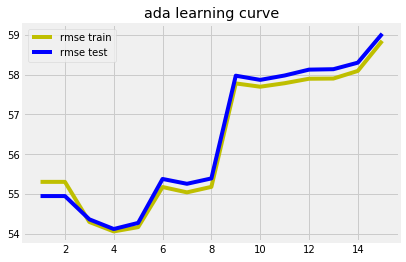

In [30]:
train_line_loss_ada = pickle.load(open('train_line_loss_ada','rb'))
test_line_loss_ada = pickle.load(open('test_line_loss_ada','rb'))
plt.plot(range(1,16),train_line_loss_ada,'y',label = 'rmse train')
plt.plot(range(1,16),test_line_loss_ada,'b', label = 'rmse test')
plt.title('ada learning curve')
plt.legend()

In [31]:
dict_to_compare_train['AdaBoost'] = train_line_loss_ada[3]
dict_to_compare_test['AdaBoost'] = test_line_loss_ada[3]

### Gradient boosting regressor

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

start_time = time.time()

regr = GradientBoostingRegressor(random_state=1)
params_regr = {'max_depth':[3,4,5],
                  'n_estimators':[110,130,150]}
grid_regr = GridSearchCV(estimator=regr,param_grid=params_regr,cv=4,n_jobs=-1,verbose = 1)
grid_regr.fit(X_train,y_train)
best_model = grid_regr.best_estimator_
pickle.dump(best_model,open('best_model_gb_gs','wb'))
print(grid_regr.best_params_ )
print("--- %s minuts ---" % ((time.time() - start_time)/60))

best_model = pickle.load(open('best_model_gb_gs','rb'))
y_grboost_train_pred = best_model.predict(X_train)
y_grboost_test_pred = best_model.predict(X_test)
dict_to_compare_train['GradientBoost'] = MSE(y_train,y_grboost_train_pred)**0.5
dict_to_compare_test['GradientBoost'] = MSE(y_test,y_grboost_test_pred)**0.5

print('rmse train: ', dict_to_compare_train['GradientBoost'])
print('rmse test: ', dict_to_compare_test['GradientBoost'])

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.2min finished


{'max_depth': 5, 'n_estimators': 130}
--- 4.454845062891642 minuts ---
rmse train:  41.533727566554646
rmse test:  47.85178271494951


## Summary of regression problem

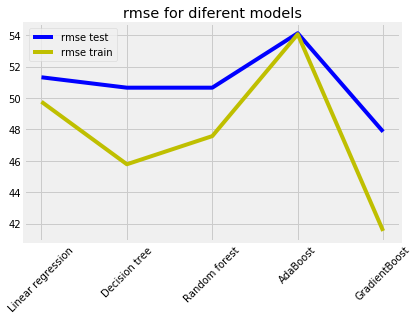

In [33]:
plt.plot(dict_to_compare_test.keys(),dict_to_compare_test.values(),'b',label = 'rmse test')
plt.plot(dict_to_compare_train.keys(),dict_to_compare_train.values(),'y',label='rmse train')
plt.title('rmse for diferent models')
plt.xticks(rotation=45)

plt.legend()

# Classification problem

In [52]:
data["category"] = np.nan

condition = data['price']<100
data['category'][condition]=1
class_1 = X_df_train[condition]

condition = (data['price']>=100)&(data['price']<200)
data['category'][condition]=2
class_2 = X_df_train[condition]

condition = data['price']>=200
data['category'][condition]=3
class_3 = X_df_train[condition]

each_category_amount = data.groupby('category').count()['name']
print(each_category_amount)

category
1.0    21866
2.0    16915
3.0     7460
Name: name, dtype: int64


/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [53]:
y_categorical = pd.get_dummies(data.category).to_numpy()
y_train_c, y_test_c = train_test_split(y_categorical,test_size=0.2,random_state = 3)
dict_to_compare_test_c = {}
dict_to_compare_train_c = {}

y_train_c_1dim, y_test_c_1dim = train_test_split(data.category,test_size=0.2,random_state = 3)

## KNN

In [54]:
from sklearn.neighbors import KNeighborsClassifier

knn= KNeighborsClassifier()
params_knn = {'n_neighbors':[20,30,100],'weights':['distance','uniform']}
grid_knn = GridSearchCV(estimator=knn,param_grid=params_knn,cv=4,n_jobs=-1,verbose=3,scoring='f1_weighted')
grid_knn.fit(X_train,y_train_c)
best_model = grid_knn.best_estimator_
print(grid_knn.best_params_ )

y_pred = best_model.predict(X_train)
dict_to_compare_train_c['KNN'] = sklearn.metrics.f1_score(y_train_c, y_pred,average='weighted')
y_pred = best_model.predict(X_test)
dict_to_compare_test_c['KNN'] = sklearn.metrics.f1_score(y_test_c, y_pred,average='weighted')
print('train weighted:',dict_to_compare_train_c['KNN'],'\ntest weighted:',dict_to_compare_test_c['KNN'])

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   13.5s finished


{'n_neighbors': 20, 'weights': 'distance'}
train weighted: 0.9999188920090503 
test weighted: 0.4763401142439365


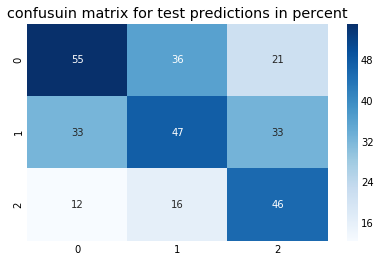

In [55]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_c.argmax(axis=1), y_pred.argmax(axis=1))
cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
import seaborn as sns
sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues')
plt.title('confusuin matrix for test predictions in percent')
plt.show()

# Decision tree classifier

In [56]:
from sklearn.tree import DecisionTreeClassifier

dt_c= DecisionTreeClassifier()
params_dt_c = {'max_depth':[10,11,12,13,14,15],
                  'min_samples_leaf':[0.0005,0.001,0.005],
                 'min_samples_split':[0.0005,0.001,0.005]}
grid_dt_c = GridSearchCV(estimator=dt_c,param_grid=params_dt_c,cv=4,n_jobs=-1,verbose=3,scoring='f1_weighted')
grid_dt_c.fit(X_train,y_train_c)
best_model = grid_dt_c.best_estimator_
pickle.dump(best_model,open('dt_c','wb'))
print(grid_dt_c.best_params_ )

best_model = pickle.load(open('dt_c','rb'))
y_pred = best_model.predict(X_train)
dict_to_compare_train_c['Decision tree'] = sklearn.metrics.f1_score(y_train_c, y_pred,average='weighted')
y_pred = best_model.predict(X_test)
dict_to_compare_test_c['Decision tree'] = sklearn.metrics.f1_score(y_test_c, y_pred,average='weighted')
print('train f1_weighted:',dict_to_compare_train_c['Decision tree'],'\ntest f1_weighted: ',dict_to_compare_test_c['Decision tree'])

Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   36.2s finished


{'max_depth': 10, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005}
train f1_weighted: 0.7544118559488835 
test f1_weighted:  0.7102971840277528


train weighted: 0.7544118559488835 
test weighted: 0.7102971840277528


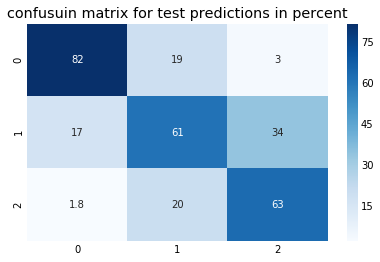

In [57]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_c.argmax(axis=1), y_pred.argmax(axis=1))
cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
print('train weighted:',dict_to_compare_train_c['Decision tree'],'\ntest weighted:',dict_to_compare_test_c['Decision tree'])
sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues')
plt.title('confusuin matrix for test predictions in percent')
plt.show()

## LogisticRegression

In [58]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class='ovr',solver='sag')
log_reg.fit(scaler.fit_transform(X_train),y_train_c_1dim)

y_pred = log_reg.predict(scaler.transform(X_train))
dict_to_compare_train_c['Logistic regression_ovr'] = sklearn.metrics.f1_score(y_train_c_1dim, y_pred,average='weighted')
y_pred = log_reg.predict(scaler.transform(X_test))
dict_to_compare_test_c['Logistic regression_ovr'] = sklearn.metrics.f1_score(y_test_c_1dim, y_pred,average='weighted')
print('train weighted:',dict_to_compare_train_c['Logistic regression_ovr'],'\ntest weightd:',dict_to_compare_test_c['Logistic regression_ovr'])

train weighted: 0.710222034779951 
test weightd: 0.704916180820397


/home/anna/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


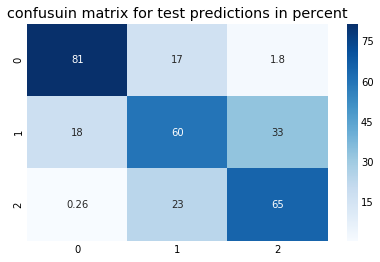

In [59]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_c_1dim, y_pred)
cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues')
plt.title('confusuin matrix for test predictions in percent')
plt.show()

In [63]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class='multinomial',solver='saga')
log_reg.fit(scaler.transform(X_train),y_train_c_1dim)
y_pred = log_reg.predict(scaler.transform(X_train))
dict_to_compare_train_c['Logistic regression_multinomial'] = sklearn.metrics.f1_score(y_train_c_1dim, y_pred,average='weighted')
y_pred = log_reg.predict(scaler.transform(X_test))
dict_to_compare_test_c['Logistic regression_multinomial'] = sklearn.metrics.f1_score(y_test_c_1dim, y_pred,average='weighted')
print('train f1 weighted:',dict_to_compare_train_c['Logistic regression_multinomial'],'\ntest f1 weighted:',dict_to_compare_test_c['Logistic regression_multinomial'])

train f1 weighted: 0.721995758550603 
test f1 weighted: 0.7116375748914887


/home/anna/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


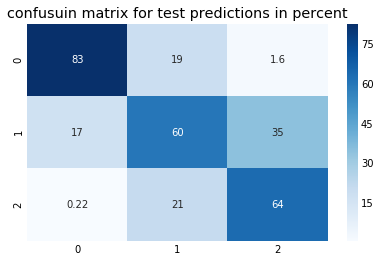

In [64]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_c_1dim, y_pred)
cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues')
plt.title('confusuin matrix for test predictions in percent')
plt.show()

## Summary of classification problem

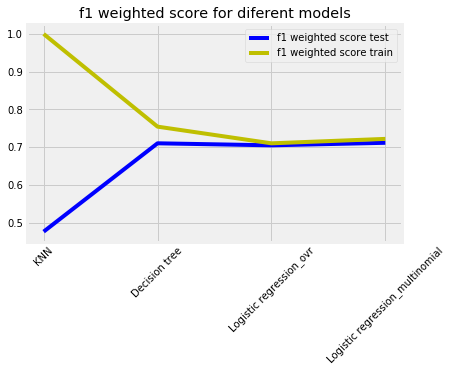

In [65]:
plt.plot(dict_to_compare_test_c.keys(),dict_to_compare_test_c.values(),'b',label = 'f1 weighted score test')
plt.plot(dict_to_compare_train_c.keys(),dict_to_compare_train_c.values(),'y',label='f1 weighted score train')
plt.title('f1 weighted score for diferent models')
plt.xticks(rotation=45)

plt.legend()